# Matsuno Shallow Water Model Examples

This notebook demonstrates the Matsuno shallow water equations on an equatorial beta plane,
showing the propagation of Kelvin and Rossby waves.

Based on Matsuno (1966) formulation for equatorial wave dynamics.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
print("JAX device:", jax.devices())
import jax.numpy as jnp

from matsuno_shallow_water import create_matsuno_model, MatsunoConfig, MatsunoModel

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 12

JAX device: [CpuDevice(id=0)]


## 1. Model Setup and Parameters

First, let's examine the model parameters and stability criteria.

In [3]:
# Create model with atmospheric parameters
model = create_matsuno_model(
    equivalent_depth=25.0,  # 25 m - typical for atmospheric first baroclinic mode
    dt_minutes=5.0,         # 5 minute time step
    nt=576                  # 2 days of simulation
)

print("=== Matsuno Model Parameters ===")
print(f"Domain: {model.config.lat_min}° to {model.config.lat_max}°N")
print(f"        {model.config.lon_min}° to {model.config.lon_max}°E")
print(f"Grid: {model.config.nlat} x {model.config.nlon}")
print(f"Resolution: {model.dlat:.2f}° lat x {model.dlon:.2f}° lon")
print(f"           {model.dy/1000:.1f} km x {model.dx/1000:.1f} km")

print(f"\n=== Physical Parameters ===")
print(f"Equivalent depth: {model.config.equivalent_depth} m")
print(f"Wave speed: {model.c:.1f} m/s")
print(f"Beta parameter: {model.config.beta:.2e} m⁻¹s⁻¹")
print(f"Equatorial deformation radius: {model.L_eq/1000:.0f} km")

print(f"\n=== Time Integration ===")
print(f"Time step: {model.config.dt} s ({model.config.dt/60:.1f} min)")
print(f"Total time: {model.config.nt * model.config.dt / 3600:.1f} hours")
print(f"CFL number (x): {model.cfl_x:.3f}")
print(f"CFL number (y): {model.cfl_y:.3f}")

# Stability check
max_cfl = max(model.cfl_x, model.cfl_y)
if max_cfl < 1.0:
    print(f"✓ Stable: max CFL = {max_cfl:.3f} < 1.0")
else:
    print(f"⚠ Potentially unstable: max CFL = {max_cfl:.3f} > 1.0")

=== Matsuno Model Parameters ===
Domain: -15.0° to 15.0°N
        0.0° to 120.0°E
Grid: 61 x 241
Resolution: 0.50° lat x 0.50° lon
           55.6 km x 55.6 km

=== Physical Parameters ===
Equivalent depth: 25.0 m
Wave speed: 15.7 m/s
Beta parameter: 2.29e-11 m⁻¹s⁻¹
Equatorial deformation radius: 827 km

=== Time Integration ===
Time step: 300.0 s (5.0 min)
Total time: 48.0 hours
CFL number (x): 0.085
CFL number (y): 0.085
✓ Stable: max CFL = 0.085 < 1.0


## 2. Equatorial Kelvin Wave Init

Kelvin waves are eastward-propagating, equatorially-trapped waves with:
- Phase speed = c = √(gH)
- Meridional scale = L_eq = √(c/β)
- No meridional velocity (v = 0)

Running Kelvin wave simulation...
✓ Simulation complete: 577 time steps


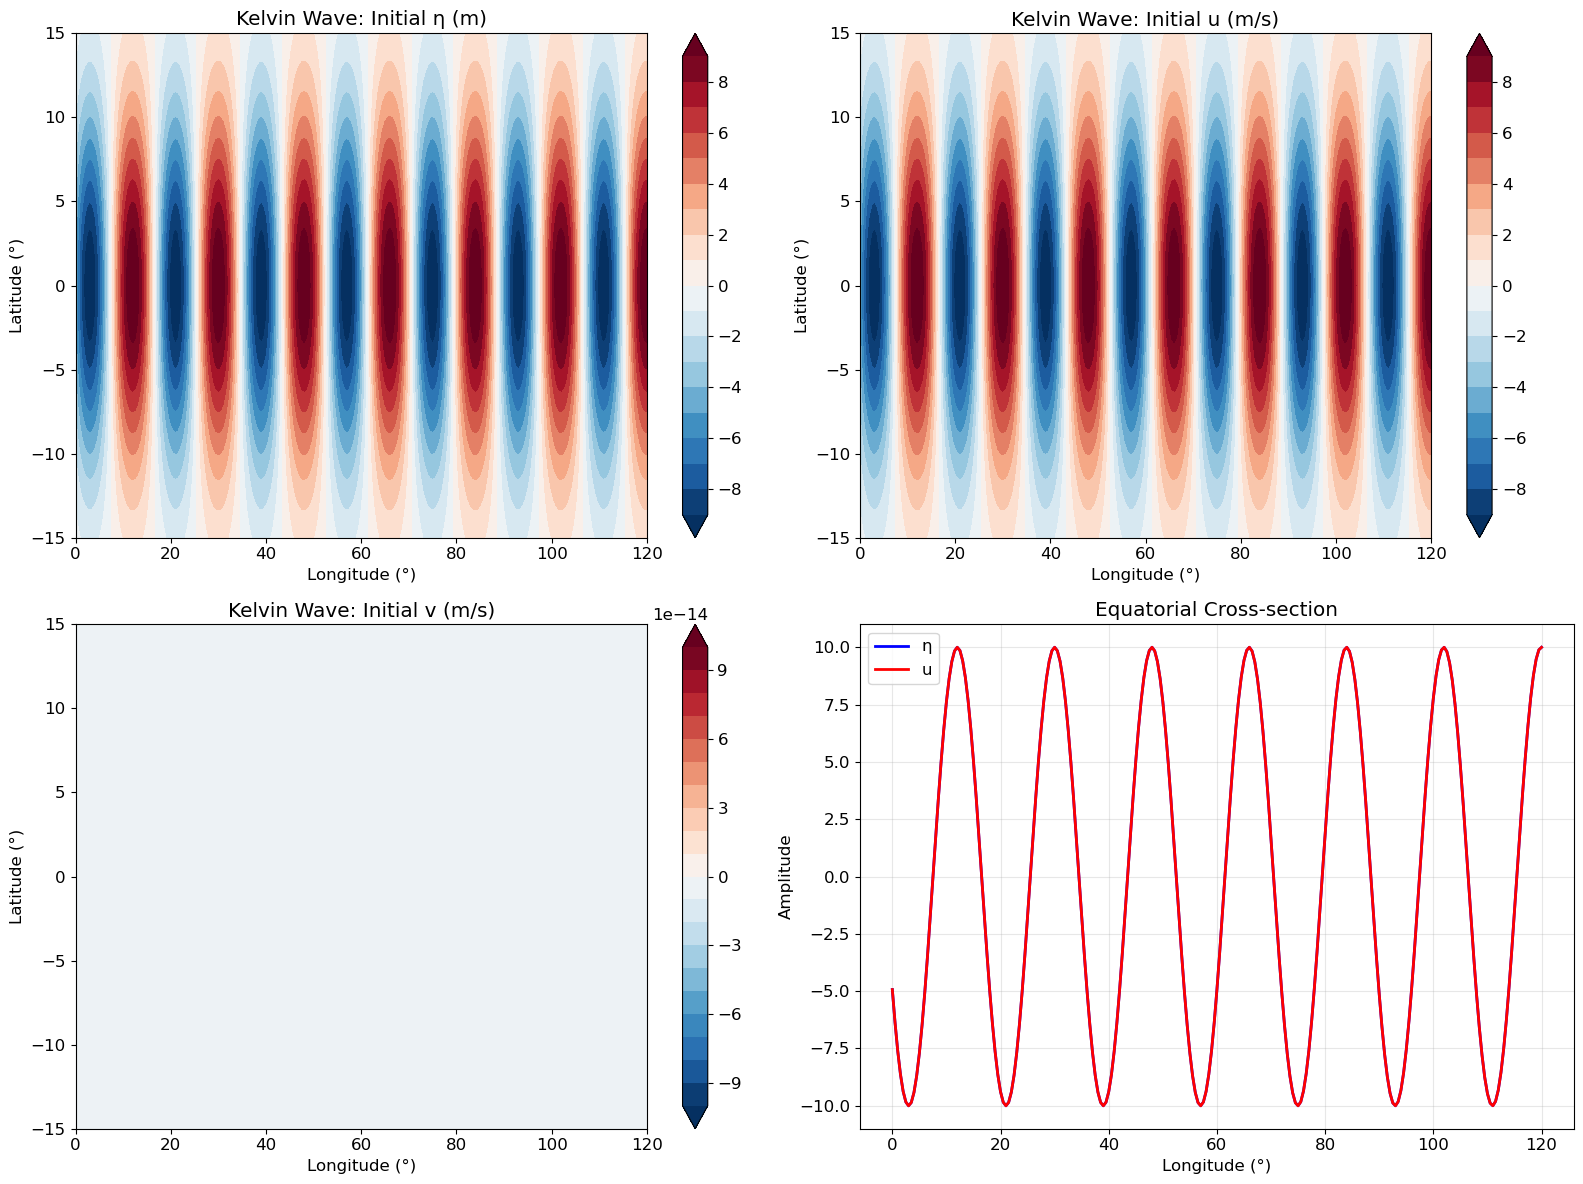

In [4]:
# Initialize Kelvin wave
kelvin_initial = model.initialize_kelvin_wave(
    amplitude=10.0,         # 10 m amplitude (atmospheric scale)
    wavelength=2000e3,      # 2000 km wavelength
    lon_center=30.0         # Start at 30°E
)

print("Running Kelvin wave simulation...")
kelvin_states = model.integrate(kelvin_initial)
kelvin_ds = model.to_xarray(kelvin_states)
print(f"✓ Simulation complete: {len(kelvin_ds.time)} time steps")

# Plot initial conditions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Surface height
im1 = axes[0,0].contourf(model.lon, model.lat, kelvin_initial[2], 
                        levels=20, cmap='RdBu_r', extend='both')
axes[0,0].set_title('Kelvin Wave: Initial η (m)')
axes[0,0].set_xlabel('Longitude (°)')
axes[0,0].set_ylabel('Latitude (°)')
plt.colorbar(im1, ax=axes[0,0])

# Zonal velocity
im2 = axes[0,1].contourf(model.lon, model.lat, kelvin_initial[0], 
                        levels=20, cmap='RdBu_r', extend='both')
axes[0,1].set_title('Kelvin Wave: Initial u (m/s)')
axes[0,1].set_xlabel('Longitude (°)')
axes[0,1].set_ylabel('Latitude (°)')
plt.colorbar(im2, ax=axes[0,1])

# Meridional velocity (should be zero)
im3 = axes[1,0].contourf(model.lon, model.lat, kelvin_initial[1], 
                        levels=20, cmap='RdBu_r', extend='both')
axes[1,0].set_title('Kelvin Wave: Initial v (m/s)')
axes[1,0].set_xlabel('Longitude (°)')
axes[1,0].set_ylabel('Latitude (°)')
plt.colorbar(im3, ax=axes[1,0])

# Cross-section at equator
eq_idx = len(model.lat) // 2
axes[1,1].plot(model.lon, kelvin_initial[2, eq_idx, :], 'b-', linewidth=2, label='η')
axes[1,1].plot(model.lon, kelvin_initial[0, eq_idx, :], 'r-', linewidth=2, label='u')
axes[1,1].set_xlabel('Longitude (°)')
axes[1,1].set_ylabel('Amplitude')
axes[1,1].set_title('Equatorial Cross-section')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Kelvin Wave Propagation

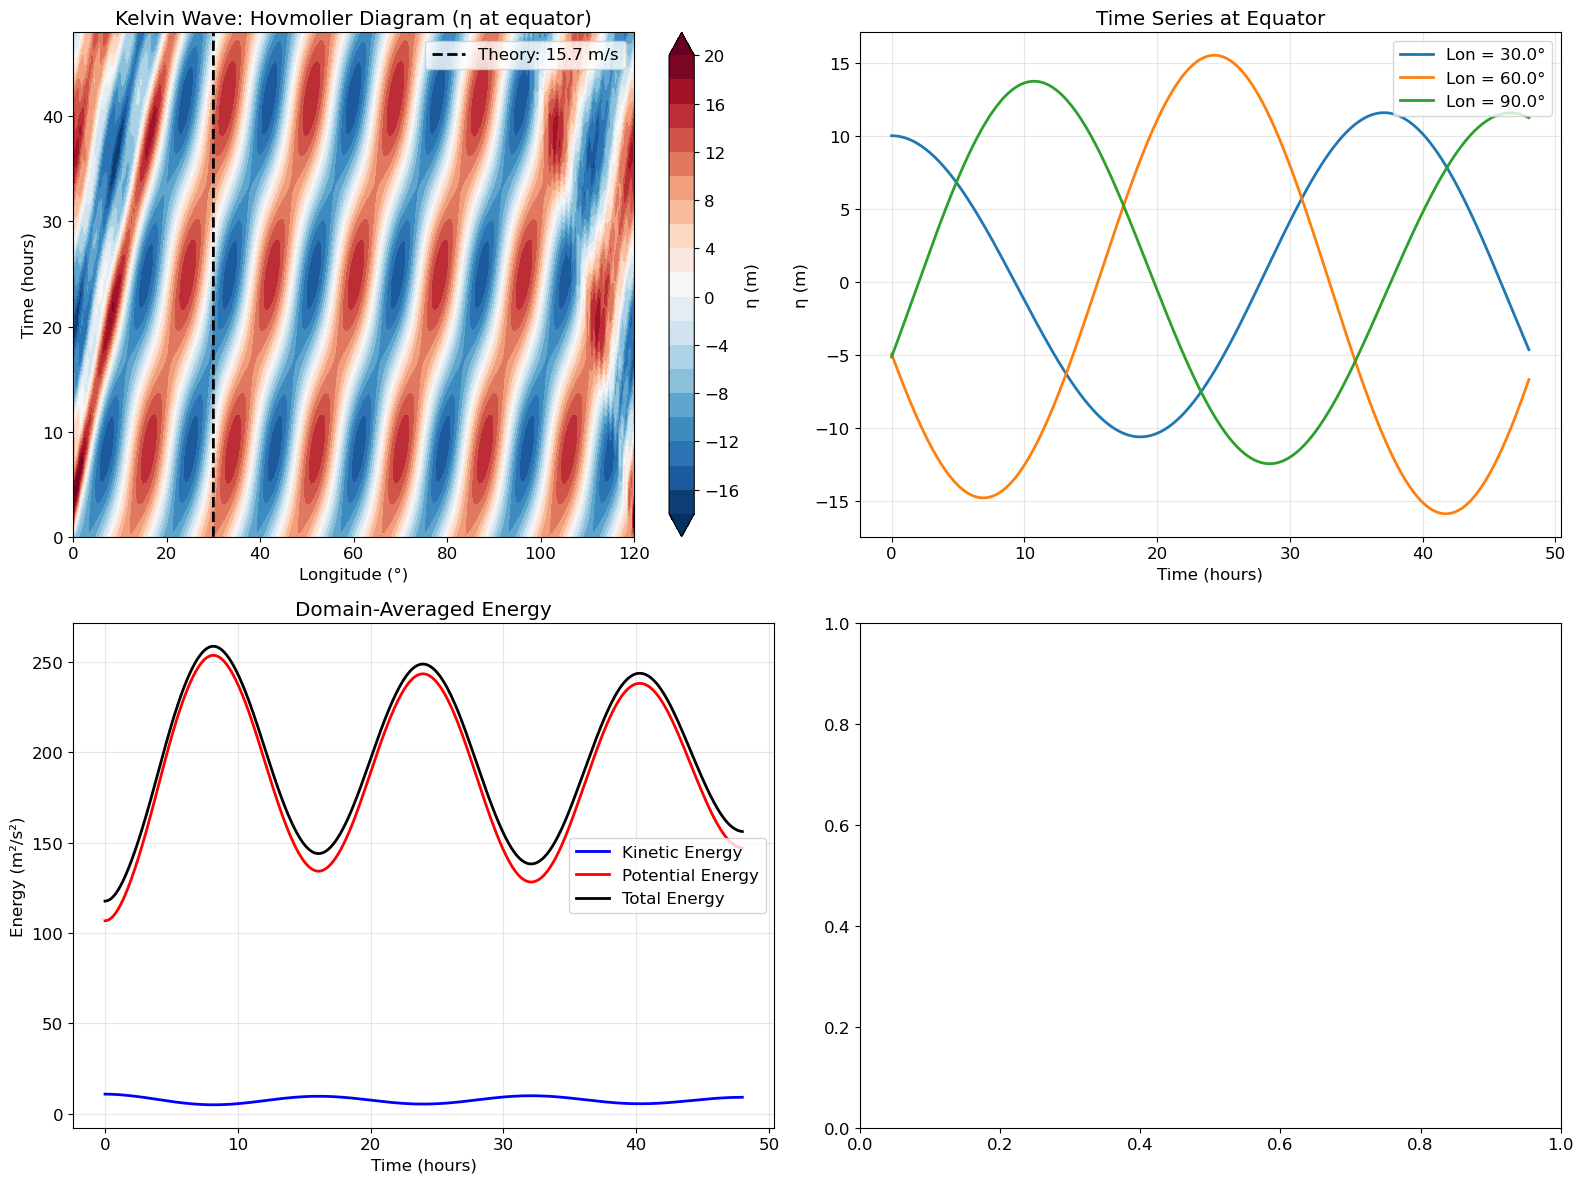

Energy conservation: 32.707% change over simulation


In [8]:
# Analyze Kelvin wave propagation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Hovmoller diagram (time-longitude at equator)
eq_idx = len(model.lat) // 2
eta_eq = kelvin_ds.eta[:, eq_idx, :]

im1 = axes[0,0].contourf(kelvin_ds.lon, kelvin_ds.time, eta_eq, 
                        levels=20, cmap='RdBu_r', extend='both')
axes[0,0].set_xlabel('Longitude (°)')
axes[0,0].set_ylabel('Time (hours)')
axes[0,0].set_title('Kelvin Wave: Hovmoller Diagram (η at equator)')
plt.colorbar(im1, ax=axes[0,0], label='η (m)')

# Add theoretical phase speed line
theoretical_speed_deg_per_hour = model.c * 3600 / (model.config.earth_radius * np.pi / 180)
time_range = np.linspace(0, kelvin_ds.time[-1].values, 100)
lon_theory = 30.0 + theoretical_speed_deg_per_hour * time_range / 3600
axes[0,0].plot(lon_theory, time_range, 'k--', linewidth=2, label=f'Theory: {model.c:.1f} m/s')
axes[0,0].legend()

# Time series at different longitudes
lon_indices = [60, 120, 180]  # Different longitude indices
for i, lon_idx in enumerate(lon_indices):
    if lon_idx < len(model.lon):
        lon_val = model.lon[lon_idx]
        eta_series = kelvin_ds.eta[:, eq_idx, lon_idx]
        axes[0,1].plot(kelvin_ds.time, eta_series, 
                      linewidth=2, label=f'Lon = {lon_val:.1f}°')

axes[0,1].set_xlabel('Time (hours)')
axes[0,1].set_ylabel('η (m)')
axes[0,1].set_title('Time Series at Equator')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Energy analysis
ke = 0.5 * (kelvin_ds.u**2 + kelvin_ds.v**2)
pe = 0.5 * model.config.g * kelvin_ds.eta**2

ke_avg = ke.mean(dim=['lat', 'lon'])
pe_avg = pe.mean(dim=['lat', 'lon'])
total_energy = ke_avg + pe_avg

axes[1,0].plot(kelvin_ds.time, ke_avg, 'b-', linewidth=2, label='Kinetic Energy')
axes[1,0].plot(kelvin_ds.time, pe_avg, 'r-', linewidth=2, label='Potential Energy')
axes[1,0].plot(kelvin_ds.time, total_energy, 'k-', linewidth=2, label='Total Energy')
axes[1,0].set_xlabel('Time (hours)')
axes[1,0].set_ylabel('Energy (m²/s²)')
axes[1,0].set_title('Domain-Averaged Energy')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print energy conservation
energy_change = (total_energy[-1] - total_energy[0]) / total_energy[0] * 100
print(f"Energy conservation: {energy_change.values:.3f}% change over simulation")

## 4. Equatorial Rossby Wave Init

Rossby waves are westward-propagating with:
- Slower phase speeds than Kelvin waves
- Off-equatorial maximum amplitude
- Different meridional mode structures

Running Rossby wave simulation...
✓ Simulation complete


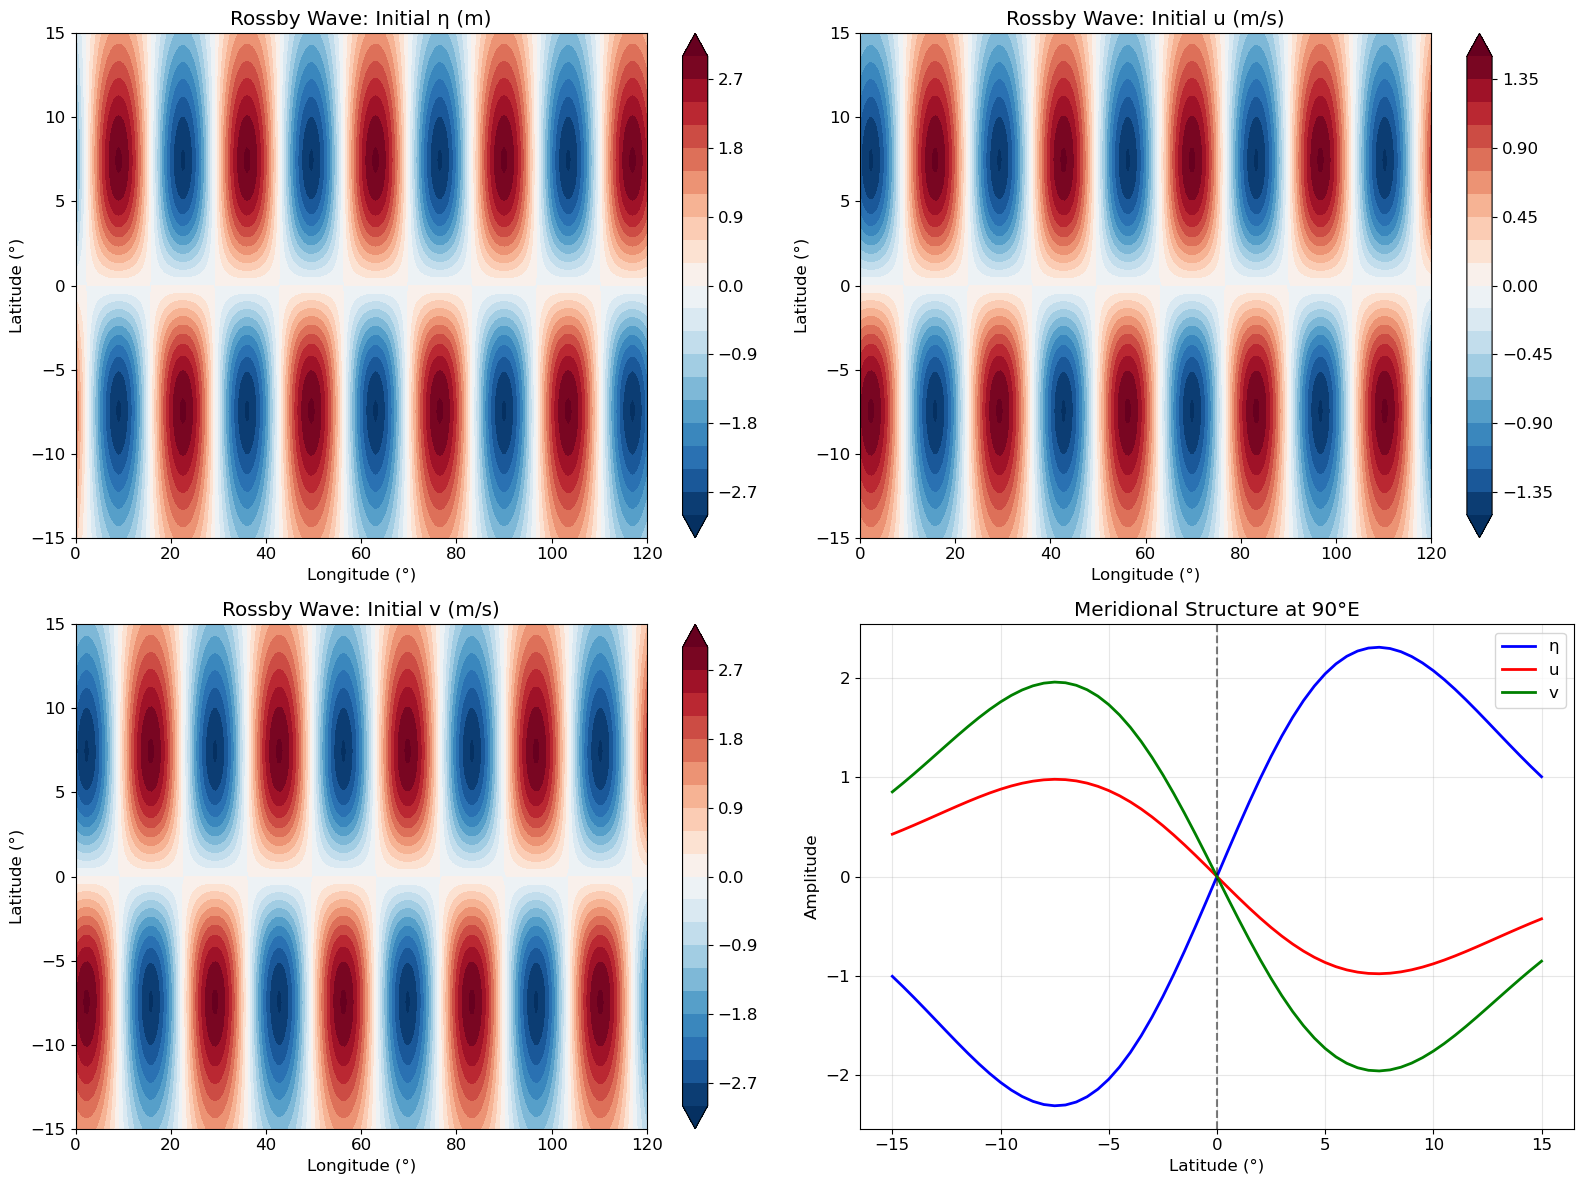

In [9]:
# Initialize Rossby wave (mode 1)
rossby_initial = model.initialize_rossby_wave(
    amplitude=5.0,          # 5 m amplitude
    wavelength=3000e3,      # 3000 km wavelength
    mode=1,                 # First meridional mode
    lon_center=90.0         # Start at 90°E
)

print("Running Rossby wave simulation...")
rossby_states = model.integrate(rossby_initial)
rossby_ds = model.to_xarray(rossby_states)
print(f"✓ Simulation complete")

# Plot Rossby wave structure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Surface height
im1 = axes[0,0].contourf(model.lon, model.lat, rossby_initial[2], 
                        levels=20, cmap='RdBu_r', extend='both')
axes[0,0].set_title('Rossby Wave: Initial η (m)')
axes[0,0].set_xlabel('Longitude (°)')
axes[0,0].set_ylabel('Latitude (°)')
plt.colorbar(im1, ax=axes[0,0])

# Zonal velocity
im2 = axes[0,1].contourf(model.lon, model.lat, rossby_initial[0], 
                        levels=20, cmap='RdBu_r', extend='both')
axes[0,1].set_title('Rossby Wave: Initial u (m/s)')
axes[0,1].set_xlabel('Longitude (°)')
axes[0,1].set_ylabel('Latitude (°)')
plt.colorbar(im2, ax=axes[0,1])

# Meridional velocity
im3 = axes[1,0].contourf(model.lon, model.lat, rossby_initial[1], 
                        levels=20, cmap='RdBu_r', extend='both')
axes[1,0].set_title('Rossby Wave: Initial v (m/s)')
axes[1,0].set_xlabel('Longitude (°)')
axes[1,0].set_ylabel('Latitude (°)')
plt.colorbar(im3, ax=axes[1,0])

# Meridional structure at 90°E
lon_idx = len(model.lon) // 2
axes[1,1].plot(model.lat, rossby_initial[2, :, lon_idx], 'b-', linewidth=2, label='η')
axes[1,1].plot(model.lat, rossby_initial[0, :, lon_idx], 'r-', linewidth=2, label='u')
axes[1,1].plot(model.lat, rossby_initial[1, :, lon_idx], 'g-', linewidth=2, label='v')
axes[1,1].set_xlabel('Latitude (°)')
axes[1,1].set_ylabel('Amplitude')
axes[1,1].set_title('Meridional Structure at 90°E')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axvline(0, color='k', linestyle='--', alpha=0.5, label='Equator')

plt.tight_layout()
plt.show()

## 5. Gaussian Perturbation - Kelvin and Rossby Waves

A localized perturbation will decompose into both Kelvin and Rossby waves, demonstrating the natural wave modes of the equatorial beta plane.

Running Gaussian perturbation simulation...
✓ Simulation complete


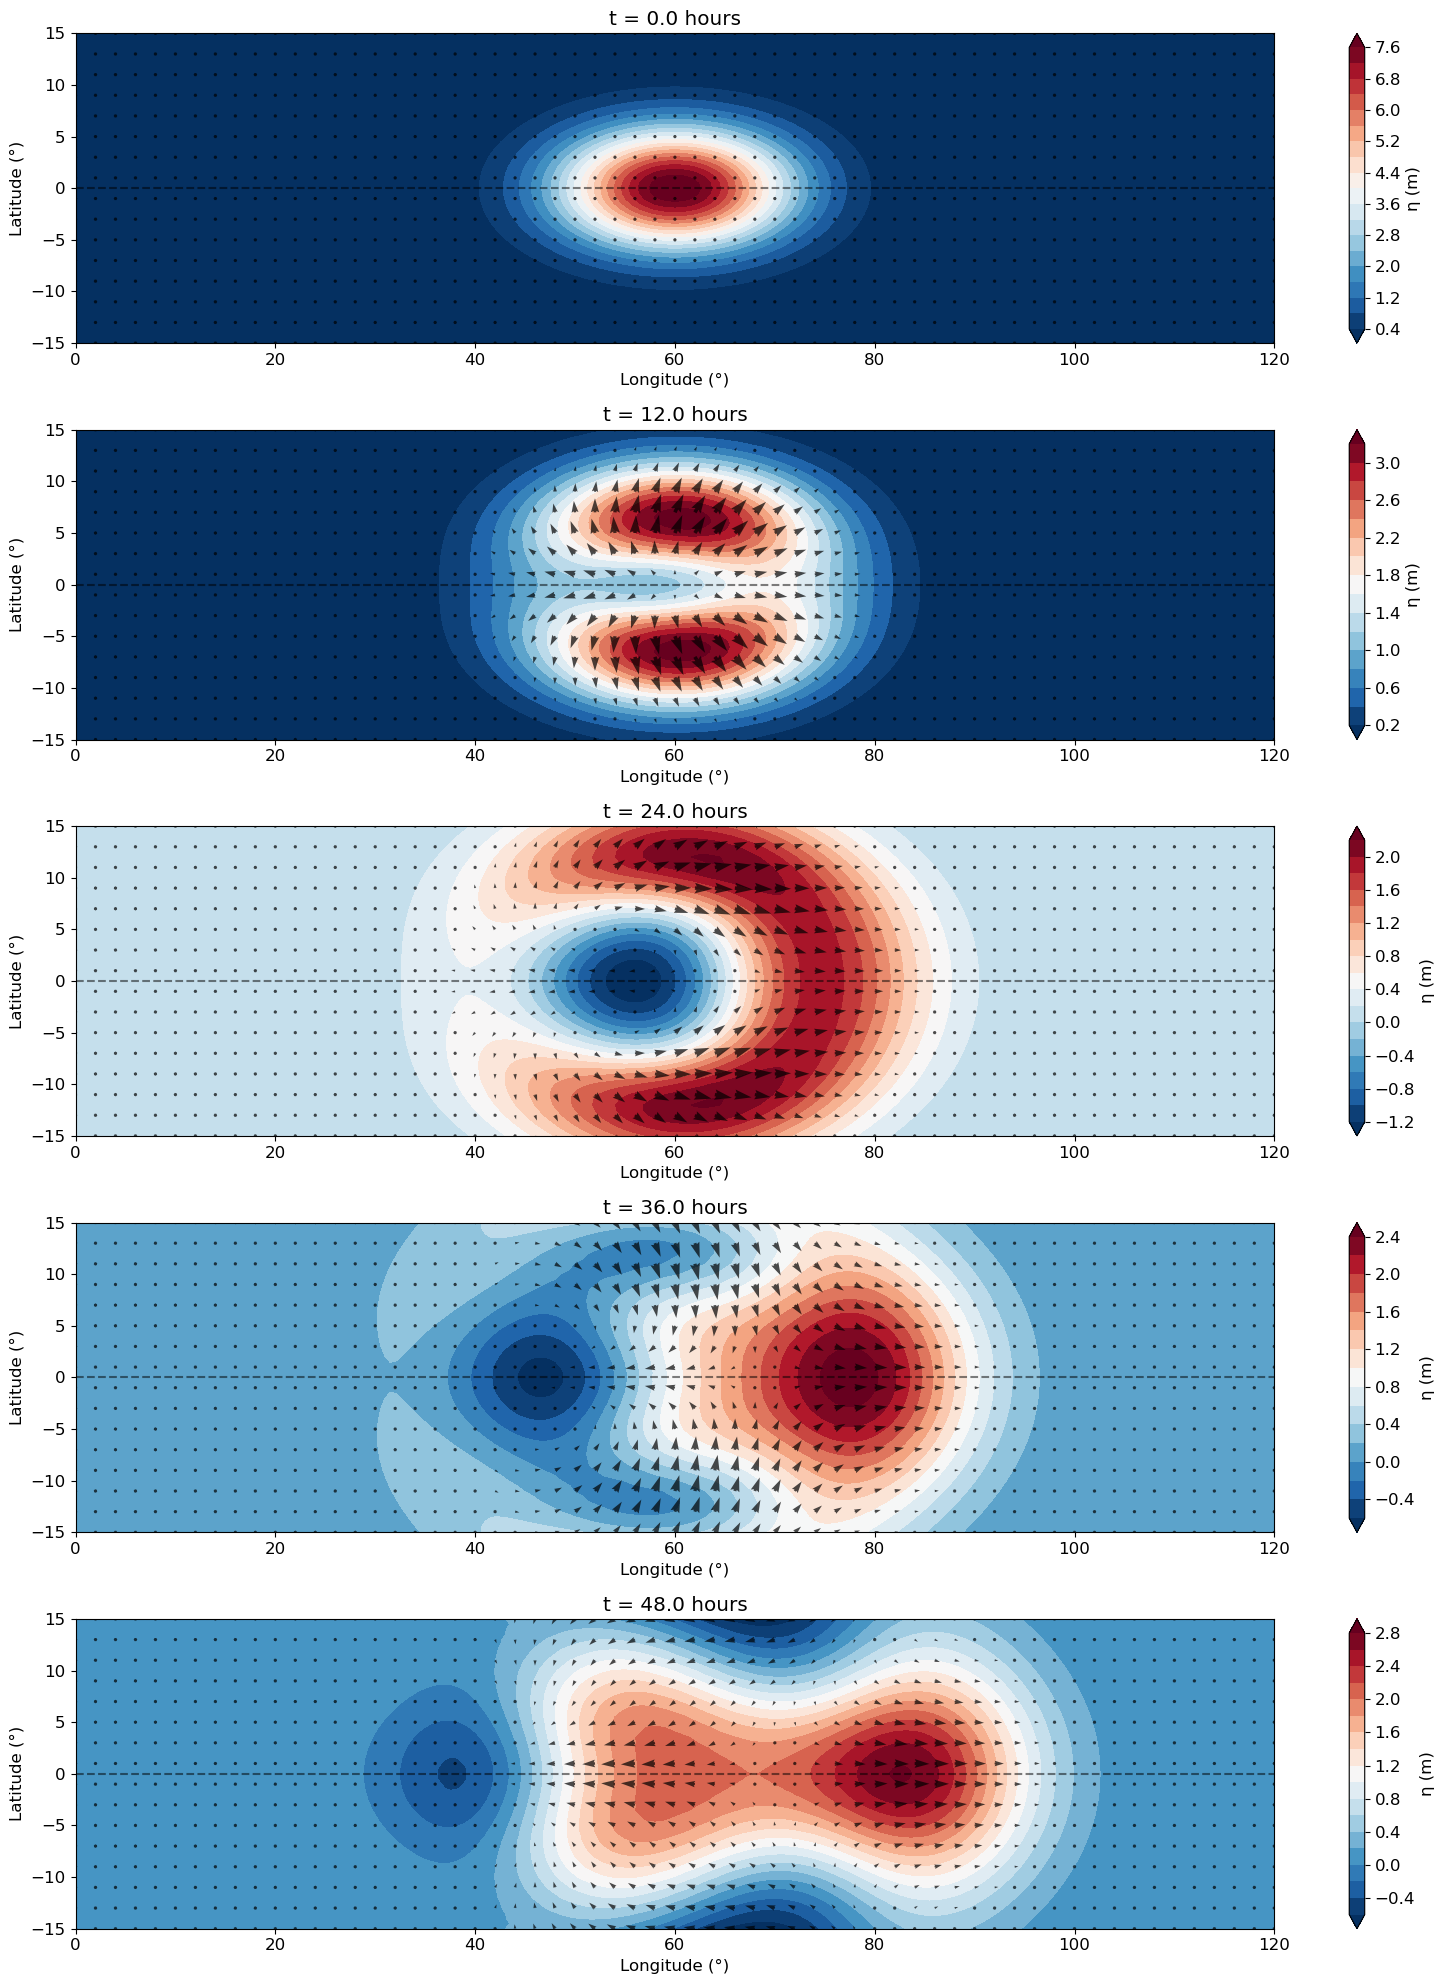

In [14]:
# Initialize Gaussian perturbation
gaussian_initial = model.initialize_gaussian_perturbation(
    amplitude=8.0,          # 8 m amplitude
    lon_center=60.0,        # Center at 60°E
    lat_center=0.0,         # At equator
    sigma_lon=8.0,          # 8° longitude width
    sigma_lat=4.0           # 4° latitude width
)

print("Running Gaussian perturbation simulation...")
gaussian_states = model.integrate(gaussian_initial)
gaussian_ds = model.to_xarray(gaussian_states)
print(f"✓ Simulation complete")

# Show wave decomposition at different times
time_indices = [0, 144, 288, 432, 576]  # 0, 12, 24, 36, 48 hours
fig, axes = plt.subplots(len(time_indices), 1, figsize=(16, 20))

for i, t_idx in enumerate(time_indices):
    if t_idx < len(gaussian_ds.time):
        time_hours = gaussian_ds.time[t_idx].values
        
        im = axes[i].contourf(gaussian_ds.lon, gaussian_ds.lat, 
                             gaussian_ds.eta[t_idx], 
                             levels=20, cmap='RdBu_r', extend='both')
        
        # Add wind vectors (subsampled)
        skip = 4
        axes[i].quiver(gaussian_ds.lon[::skip], gaussian_ds.lat[::skip],
                      gaussian_ds.u[t_idx, ::skip, ::skip], 
                      gaussian_ds.v[t_idx, ::skip, ::skip],
                      scale=130, alpha=0.7, width=0.003)
        
        axes[i].set_title(f't = {time_hours:.1f} hours')
        axes[i].set_xlabel('Longitude (°)')
        axes[i].set_ylabel('Latitude (°)')
        
        # Add colorbar
        plt.colorbar(im, ax=axes[i], label='η (m)')
        
        # Indicate equator
        axes[i].axhline(0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 6. Stability Analysis and Time Scale Tests

Test different time steps to determine stability limits.

Testing stability for different time steps...
✓ dt =  2.0 min, CFL = 0.034, growth = 1.27
✓ dt =  6.2 min, CFL = 0.105, growth = 1.46
✓ dt = 10.4 min, CFL = 0.177, growth = 1.39
✓ dt = 14.7 min, CFL = 0.248, growth = 1.53
✓ dt = 18.9 min, CFL = 0.319, growth = 1.37
✓ dt = 23.1 min, CFL = 0.391, growth = 1.58
✓ dt = 27.3 min, CFL = 0.462, growth = 1.43
✓ dt = 31.6 min, CFL = 0.533, growth = 1.64
✓ dt = 35.8 min, CFL = 0.605, growth = 1.54
✓ dt = 40.0 min, CFL = 0.676, growth = 1.64


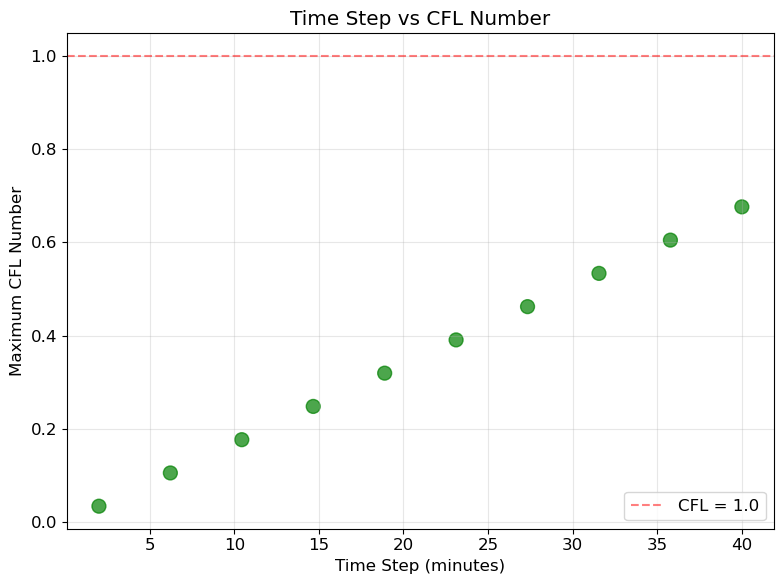

In [20]:
# Test different time steps
dt_tests = np.linspace(2,40,10)  # minutes
stability_results = []

print("Testing stability for different time steps...")

for dt_min in dt_tests:
    # Create short test model
    test_model = create_matsuno_model(
        equivalent_depth=25.0,
        dt_minutes=dt_min,
        nt=60  # 1 hour test
    )
    
    # Initialize simple Kelvin wave
    test_initial = test_model.initialize_kelvin_wave(amplitude=5.0)
    
    # Run simulation
    test_states = test_model.integrate(test_initial)
    
    # Check for instability (NaN or exponential growth)
    final_max = np.max(np.abs(test_states[-1]))
    initial_max = np.max(np.abs(test_states[0]))
    growth_factor = final_max / initial_max
    
    cfl_max = max(test_model.cfl_x, test_model.cfl_y)
    
    is_stable = not (np.isnan(final_max) or growth_factor > 3.0)
    
    stability_results.append({
        'dt_min': dt_min,
        'cfl': cfl_max,
        'growth_factor': growth_factor,
        'stable': is_stable
    })
    
    status = "✓" if is_stable else "✗"
    print(f"{status} dt = {dt_min:4.1f} min, CFL = {cfl_max:.3f}, growth = {growth_factor:.2f}")

# Plot stability results
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

dt_vals = [r['dt_min'] for r in stability_results]
cfl_vals = [r['cfl'] for r in stability_results]
growth_vals = [r['growth_factor'] for r in stability_results]
stable_vals = [r['stable'] for r in stability_results]

# CFL vs time step
colors = ['green' if s else 'red' for s in stable_vals]
axes.scatter(dt_vals, cfl_vals, c=colors, s=100, alpha=0.7)
axes.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='CFL = 1.0')
axes.set_xlabel('Time Step (minutes)')
axes.set_ylabel('Maximum CFL Number')
axes.set_title('Time Step vs CFL Number')
axes.grid(True, alpha=0.3)
axes.legend()

plt.tight_layout()
plt.show()
